## [베터리 열화 예측 및 비정상 모듈 식별]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [ ]:
datapath = './Data/distributed_bms_dataset.csv'

origin = pd.read_csv(datapath)
origin.head()

df = origin.copy()

In [ ]:
## 데이터 전처리
# 4) timestamp → datetime 변환
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 결측치 확인
print("결측치 확인:")
print(df.isna().sum())

# 기본 통계
print("\n기본 통계 요약:")
print(df.describe())

# 모듈별 데이터 분포
print("\n모듈별 샘플 개수:")
print(df['module_id'].value_counts())

## 유니크 값 확인
for col in df.columns :
    print(f'[{col}] ============ {df[col].nunique()}개')
    print(f'{df[col].unique()}')
    

결측치 확인:
timestamp                0
module_id                0
cell_voltage_v           0
cell_temperature_c       0
module_current_a         0
module_power_kw          0
converter_command_pct    0
soc_pct                  0
soh_pct                  0
anomaly_score_pct        0
diagnostic_flag          0
latency_ms               0
dtype: int64

기본 통계 요약:
                 timestamp  cell_voltage_v  cell_temperature_c  \
count                  600      600.000000          600.000000   
mean   2025-05-16 14:12:30        3.700512           28.732917   
min    2025-05-16 08:00:00        3.636000           24.780000   
25%    2025-05-16 11:05:00        3.687000           26.887500   
50%    2025-05-16 14:12:30        3.700000           28.740000   
75%    2025-05-16 17:20:00        3.714000           30.597500   
max    2025-05-16 20:25:00        3.757000           32.660000   
std                    NaN        0.019868            2.177533   

       module_current_a  module_power_kw  convert

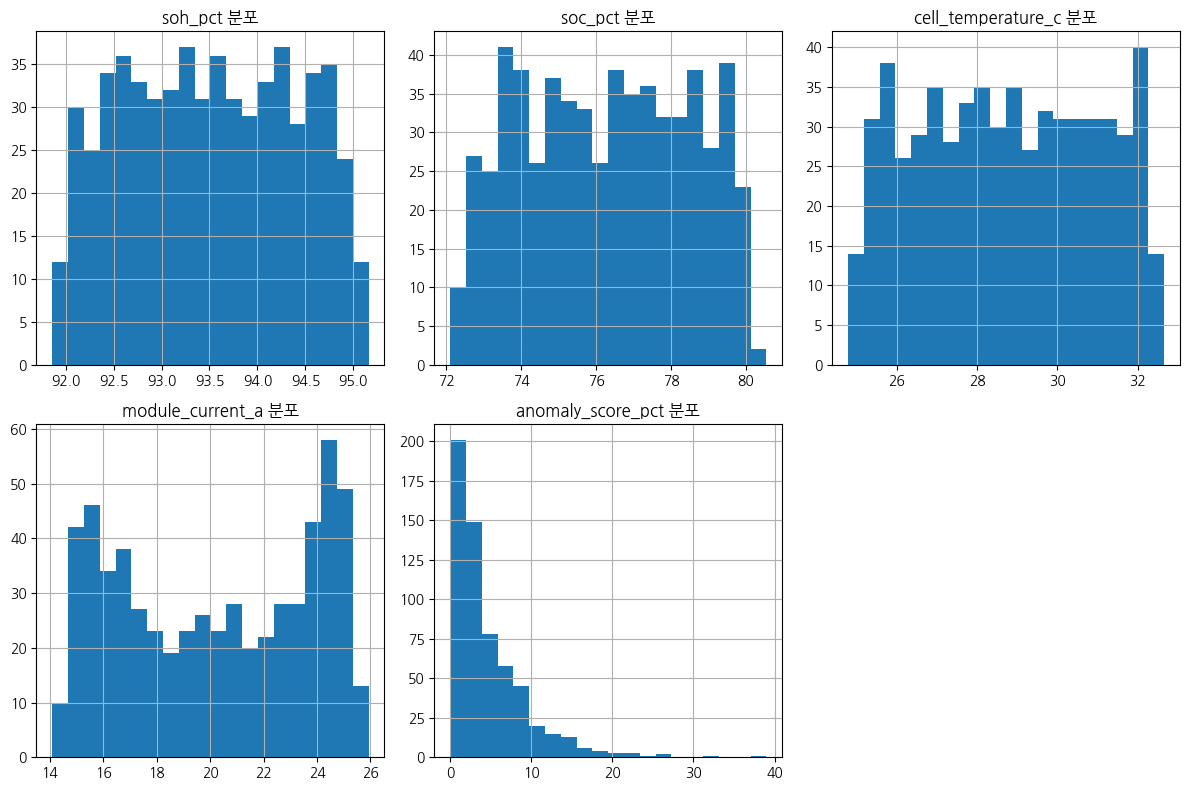

In [ ]:

cols_to_plot = ['soh_pct', 'soc_pct', 'cell_temperature_c', 
                'module_current_a', 'anomaly_score_pct']

plt.figure(figsize=(12, 8))

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(2, 3, i)
    plt.hist(df[col], bins=20)
    plt.title(f"{col} 분포")
    plt.grid(True)

plt.tight_layout()
plt.show()

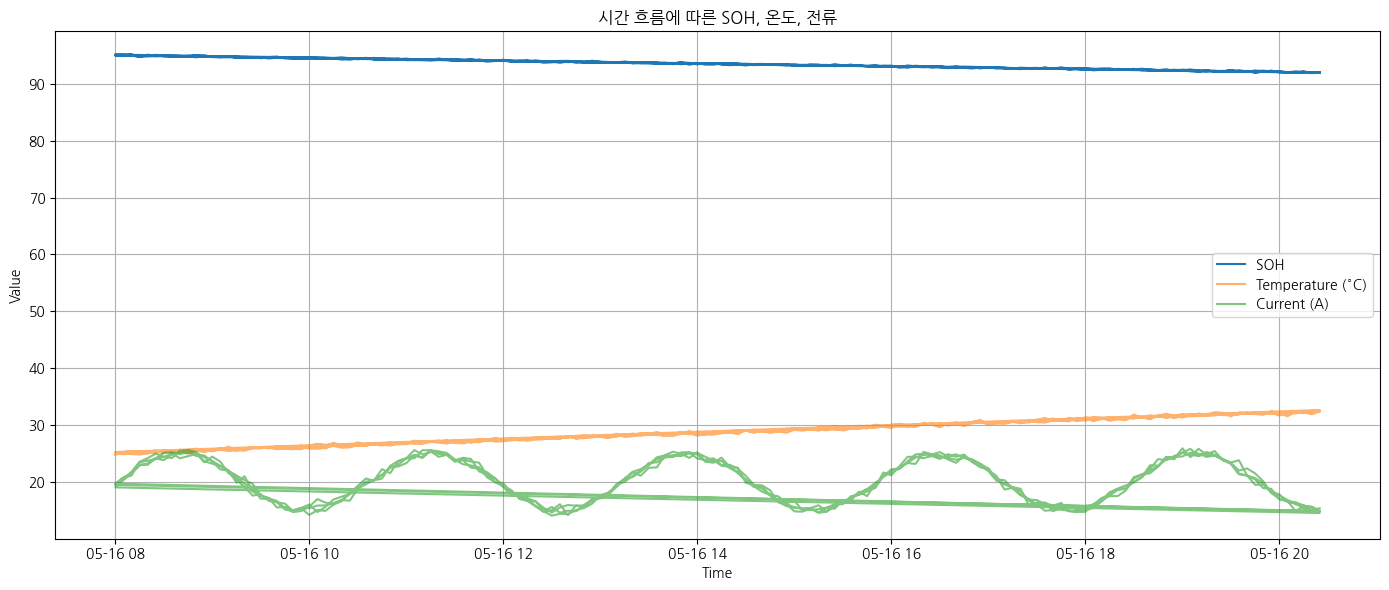

In [ ]:
## 시간에 따른 주요 값들 비교
plt.figure(figsize=(14,6))
plt.plot(df['timestamp'], df['soh_pct'], label='SOH')
plt.plot(df['timestamp'], df['cell_temperature_c'], label='Temperature (°C)', alpha=0.6)
plt.plot(df['timestamp'], df['module_current_a'], label='Current (A)', alpha=0.6)

plt.legend()
plt.title("시간 흐름에 따른 SOH, 온도, 전류")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
## 분석1. 열화 영향요인(온도/전류/SOC 패턴) 탐색 - 상관관계 기반 탐색 가능
# 상관 분석 대상 컬럼 설정
corr_cols = ['soh_pct', 'cell_temperature_c', 'module_current_a', 'soc_pct']

# 상관계수 계산
corr = df[corr_cols].corr()

# SOH 기준 정렬
soh_corr_sorted = corr['soh_pct'].sort_values(ascending=False)
soh_corr_sorted


# 분석 결과
# SOC(충전상태)	            +0.99 매우 높은 양의 상관	  SOC가 높을수록 SOH가 높게 기록됨 → 저SOC에서 열화 리스크 증가 가능성
# 온도(Cell Temperature)	-0.99 매우 높은 음의 상관	 온도가 높아질수록 SOH가 낮아짐 → 고온이 열화의 가장 큰 위험요인
# 전류(Module Current)	    +0.09 (거의 무관)	        현재 데이터 범위에서는 영향 미미
# SOH	                    1.0	자기 자신

## ==> 고온 + 저SOC 운행 조건에서 열화 리스크 급증 가능성이 매우 높다


soh_pct               1.000000
soc_pct               0.990537
module_current_a      0.092438
cell_temperature_c   -0.990055
Name: soh_pct, dtype: float64

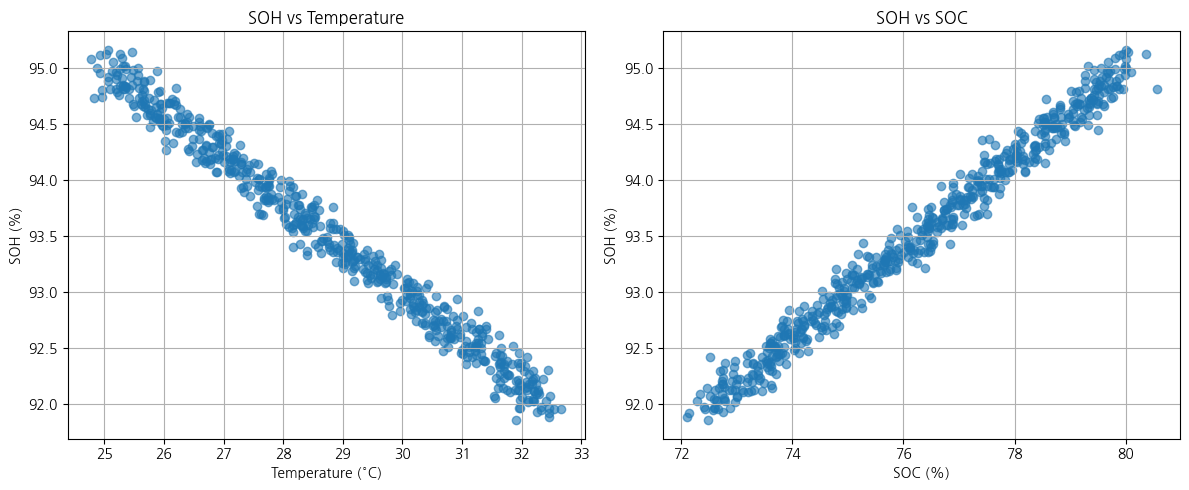

In [ ]:
## 분석1. 시각화 (soh와 온도, soc 산점도 비교)
plt.figure(figsize=(12, 5))

# SOH vs Temperature
plt.subplot(1, 2, 1)
plt.scatter(df['cell_temperature_c'], df['soh_pct'], alpha=0.6)
plt.title("SOH vs Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("SOH (%)")
plt.grid(True)

# SOH vs SOC
plt.subplot(1, 2, 2)
plt.scatter(df['soc_pct'], df['soh_pct'], alpha=0.6)
plt.title("SOH vs SOC")
plt.xlabel("SOC (%)")
plt.ylabel("SOH (%)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def predict_degradation(row):
    """배터리 열화 위험도를 계산하여 0~100 점수 반환"""

    risk = 0
    
    # 1) 온도 리스크
    if row['cell_temperature_c'] > 30:
        risk += (row['cell_temperature_c'] - 30) * 2
    
    # 2) SOC 위험 구간  
    if row['soc_pct'] < 25:
        risk += (25 - row['soc_pct']) * 1.5
    elif row['soc_pct'] > 85:
        risk += (row['soc_pct'] - 85) * 1.5
    
    # 3) 전류 변동성 기반 스트레스 (Z-score 활용)
    # 전류 값이 극단적이면 위험 증가 (실시간 기준)
    if abs(row['module_current_a']) > 22: 
        risk += (abs(row['module_current_a']) - 22) * 1.2
    
    # 4) 시스템 anomaly 기반 영향
    risk += row['anomaly_score_pct'] * 0.8

    # 점수 상한 제한
    return min(round(risk, 2), 100)

In [ ]:
def detect_abnormal_module(df):
    """모듈별 상태 기반 비정상 여부를 반환"""
    
    abnormal_modules = []

    module_groups = df.groupby('module_id')

    for module, data in module_groups:
        
        soh_mean = data['soh_pct'].mean()
        soh_std = data['soh_pct'].std()
        anomaly_mean = data['anomaly_score_pct'].mean()
        diag_flag_count = data['diagnostic_flag'].sum()
        
        abnormal_condition = (
            soh_mean < (df['soh_pct'].mean() - 2 * df['soh_pct'].std()) or
            anomaly_mean > 20 or
            diag_flag_count > 3
        )
        
        abnormal_modules.append({
            'module_id': module,
            'avg_soh': round(soh_mean, 2),
            'avg_anomaly': round(anomaly_mean, 2),
            'diagnostic_flags': diag_flag_count,
            'status': '⚠️ 비정상' if abnormal_condition else '✅ 정상'
        })

    return abnormal_modules

## 함수 사용 예시
df['degradation_risk'] = df.apply(predict_degradation, axis=1)

abnormal_result = detect_abnormal_module(df)

display(abnormal_result)

[{'module_id': 'Module_A',
  'avg_soh': np.float64(93.49),
  'avg_anomaly': np.float64(5.01),
  'diagnostic_flags': np.int64(0),
  'status': '✅ 정상'},
 {'module_id': 'Module_B',
  'avg_soh': np.float64(93.51),
  'avg_anomaly': np.float64(4.49),
  'diagnostic_flags': np.int64(0),
  'status': '✅ 정상'},
 {'module_id': 'Module_C',
  'avg_soh': np.float64(93.51),
  'avg_anomaly': np.float64(4.55),
  'diagnostic_flags': np.int64(0),
  'status': '✅ 정상'},
 {'module_id': 'Module_D',
  'avg_soh': np.float64(93.51),
  'avg_anomaly': np.float64(4.71),
  'diagnostic_flags': np.int64(0),
  'status': '✅ 정상'}]